In [1]:
# pip install keras_preprocessing

In [2]:
import string
import re
from os import listdir
import tensorflow as tf
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPool1D
import numpy as np
import nltk

2023-12-21 19:34:31.247655: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 19:34:31.247717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 19:34:31.270837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 19:34:31.316154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 19:34:32.178241: W tensorflow/compiler/tf2

In [3]:
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename,'r')
  #read all text
  text = file.read()
  #close the file
  file.close()
  return text

In [4]:
text = load_doc('review_polarity/txt_sentoken/pos/cv026_29325.txt')
text

'for those of us who weren\'t yet born when the 1960\'s rock \'n\' rolled around , monterey pop affords an affectionate glimpse of the music that influenced our parents to be hippies . \nfrom otis redding to jimi hendrix , janis joplin to the mamas and the papas , and jefferson airplane to the who , this documentary is jam-packed with contagious energy . \nbut i give fair warning that i will reveal the ending , which does not do the rest of the film the justice it deserves . \nshot in 1969 at an outdoor concert that precluded woodstock , the film defies the stereotype of the general population at the time . \nsure , some have painted their faces and smoke joints , but d . a . \npennebaker ( the war room , moon over broadway ) surprisingly chooses to show a broad spectrum of the audience . \nno matter who is watching , it all comes back to the talented musicians that stir your soul . \nthe excitement starts before the music even begins . \na young girl is cleaning thousands of seats and

In [5]:
# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove puctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove reamaning tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [6]:
clean = clean_doc(text)
len(clean)

261

In [7]:
# load_doc, clean and return line of tokens
def doc_to_line(filename, vocab):
  # load the doc
  doc = load_doc(filename)
  # clean doc
  tokens = clean_doc(doc)
  # filter by vocab
  tokens = [w for w in tokens if w in vocab]
  return " ".join(tokens)

In [8]:
vocab = open('vocab.txt')
vocab = vocab.read().split()

In [9]:
doc_to_line('review_polarity/txt_sentoken/pos/cv026_29325.txt', vocab)

'us werent yet born rock rolled around monterey pop affectionate glimpse music influenced parents hippies otis redding jimi hendrix janis joplin mamas papas jefferson airplane documentary jampacked contagious energy give fair warning reveal ending rest film justice deserves shot outdoor concert film defies stereotype general population time sure painted faces smoke joints war room moon broadway surprisingly chooses show broad spectrum audience matter watching comes back talented musicians stir soul excitement starts music even begins young girl cleaning thousands seats asked interviewer replies feels lucky moments organized craziness john phillips leader mamas papas one concert tries get touch one band tuning member remarks finally decent sound system tell watching first moments show isnt vanity playing music love appreciation street interaction audience performer continues throughout film becomes infectious audience impossible tear eyes away janis joplin belts ballad love ball chain l

In [10]:
def process_train(directory, vocab):
  documents = list()
  for filename in listdir(directory):
    if not filename.startswith('cv9'):
      path = directory + '/' + filename
      doc = load_doc(path)
      tokens = doc_to_line(doc, vocab)
      documents.append(tokens)
    return documents

def process_test(directory, vocab):
  documents = list()
  for filename in listdir(directory):
    if filename.startswith('cv9'):
      path = directory + '/' + filename
      doc = load_doc(path)
      tokens = doc_to_line(doc, vocab)
      documents.append(tokens)
    return documents

In [11]:
# load all docs in a directory
def process_docs(directory, vocab, is_train):
    documents = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any review in the test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create the full path of file to open
        path  = directory + '/' + filename
        # load the doc
        doc = load_doc(path)
        # clean doc
        tokens = clean_doc(doc)
        # add to list
        documents.append(tokens)
    return documents
        

In [12]:
lines = process_docs('review_polarity/txt_sentoken/pos', vocab, False)
len(lines)

100

In [13]:
lines = process_docs('review_polarity/txt_sentoken/pos', vocab, True)
len(lines)

900

In [14]:
# load and clean a dataset
def load_clean_dataset(vocab, is_train):
    # load documents
    neg = process_docs('review_polarity/txt_sentoken/neg', vocab, is_train)
    pos = process_docs('review_polarity/txt_sentoken/pos', vocab, is_train)
    
    docs = neg + pos
    #prepare lables
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

In [15]:
train, train_labels = load_clean_dataset(vocab, True)
test, test_labels = load_clean_dataset(vocab, False)

len(train), len(train_labels),len(test), len(test_labels)

(1810, 1810, 200, 200)

In [16]:
# integer encode and pad documents
def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')

In [17]:
# define the model
def define_model(vocab_size,max_length):
    # Define Network
    model = Sequential()
    model.add(Embedding(vocab_size,100,input_length=max_length))
    model.add(Conv1D(filters=32,kernel_size=8,activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    # Compile Network
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics = ['accuracy'])

    # summerize Defined Model
    model.summary()
    plot_model(model,to_file='model.png',show_shapes=True)
    return model

In [18]:
# pip install pydot graphviz

In [19]:
# load the vocabulary
vocab_filname = 'vocab.txt'
vocab = load_doc(vocab_filname)
vocab = set(vocab.split())

In [20]:
# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)

In [21]:
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [22]:
# create the tokenizer
tokenizer = create_tokenizer(train_docs) 

In [23]:
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d'% vocab_size)

Vocabulary size: 44277


In [24]:
# calculate the maximum sequence length
max_length = max([len(s) for s in train_docs])
print('Maximum length: %d' % max_length)

Maximum length: 1380


In [25]:
# enocde data
Xtrain = tokenizer.texts_to_matrix(train, mode = 'binary')
Xtrain.shape

(1810, 44277)

In [26]:
Xtest = tokenizer.texts_to_matrix(test, mode = 'binary')
Xtest.shape

(200, 44277)

In [27]:
# define model
model = define_model(vocab_size, max_length)
# fit network
model.fit(Xtrain, np.array(ytrain), epochs=10, batch_size=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1380, 100)         4427700   
                                                                 
 conv1d (Conv1D)             (None, 1373, 32)          25632     
                                                                 
 max_pooling1d (MaxPooling1  (None, 686, 32)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 21952)             0         
                                                                 
 dense (Dense)               (None, 50)                1097650   
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

2023-12-21 19:34:37.302169: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 19:34:37.388608: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 19:34:37.388954: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/10


ValueError: in user code:

    File "/home/user/anaconda3/envs/NLP/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/user/anaconda3/envs/NLP/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/user/anaconda3/envs/NLP/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/user/anaconda3/envs/NLP/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/user/anaconda3/envs/NLP/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/user/anaconda3/envs/NLP/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 1380), found shape=(10, 44277)


In [ ]:
tokenizer.word_docs

defaultdict(int,
            {'guess': 174,
             'dating': 30,
             'nice': 231,
             'character': 922,
             'expecting': 64,
             'always': 388,
             'insecurities': 8,
             'upper': 27,
             'nearly': 238,
             'presumably': 28,
             'relationship': 248,
             'decide': 103,
             'wrong': 273,
             'happen': 171,
             'occasionally': 100,
             'somebodys': 2,
             'deeper': 46,
             'never': 757,
             'relate': 34,
             'inlaws': 2,
             'relating': 12,
             'asked': 80,
             'turned': 156,
             'hit': 204,
             'possibly': 104,
             'political': 82,
             'dina': 11,
             'situation': 135,
             'work': 644,
             'role': 555,
             'suddenly': 117,
             'contributes': 15,
             'little': 831,
             'husband': 135,
             'd

In [ ]:
# define network
n_words = x_train.shape[1]
model = define_model(n_words)

TypeError: define_model() missing 1 required positional argument: 'max_length'

In [ ]:
model.fit(x_train, np.array(train_labels), epochs = 10, batch_size=10)

Epoch 1/10
181/181 [==============================] - 4s 17ms/step - loss: 0.4194 - accuracy: 0.8055
Epoch 2/10
181/181 [==============================] - 3s 16ms/step - loss: 0.0228 - accuracy: 0.9983
Epoch 3/10
181/181 [==============================] - 3s 16ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 4/10
181/181 [==============================] - 3s 17ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 5/10
181/181 [==============================] - 3s 16ms/step - loss: 6.9212e-04 - accuracy: 1.0000
Epoch 6/10
181/181 [==============================] - 3s 16ms/step - loss: 3.4783e-04 - accuracy: 1.0000
Epoch 7/10
181/181 [==============================] - 3s 16ms/step - loss: 2.1718e-04 - accuracy: 1.0000
Epoch 8/10
181/181 [==============================] - 3s 16ms/step - loss: 1.4772e-04 - accuracy: 1.0000
Epoch 9/10
181/181 [==============================] - 3s 16ms/step - loss: 1.0616e-04 - accuracy: 1.0000
Epoch 10/10
181/181 [==============================] - 3s 16ms/step - l

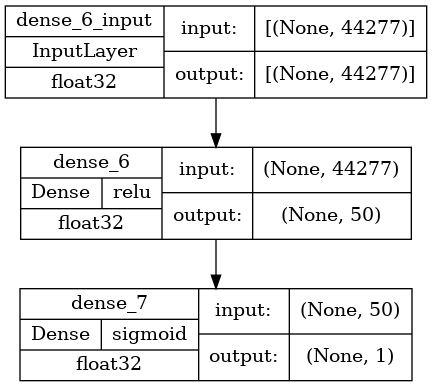

In [ ]:
plot_model(model, show_dtype=True, show_layer_activations = True, show_shapes = True, show_layer_names=True)

In [ ]:
model.evaluate(x_test,np.array(test_labels), batch_size=1)

200/200 [==============================] - 1s 4ms/step - loss: 0.2192 - accuracy: 0.9200


[0.21917930245399475, 0.9200000166893005]

In [ ]:
text1 = 'Best movie ever! It was great, I will definitely recommend it.'
text2 = 'This is a bad movie.'
text3 = 'This is a best movie'
text4 = 'The acting was bad in this movie'

In [ ]:
def predict(text):
  tokens = clean_doc(text)
  text = " ".join(tokens)
  x_test = tokenizer.texts_to_matrix([text], mode = 'binary')
  prediction = model.predict(x_test)
  if prediction >= 0.5:
    return 'Positive'
  else:
     return 'Negative'

In [ ]:
predict(text1)

1/1 [==============================] - 0s 95ms/step


'Positive'

In [ ]:
predict(text2)

1/1 [==============================] - 0s 27ms/step


'Negative'

In [ ]:
predict(text3)

1/1 [==============================] - 0s 27ms/step


'Positive'

In [ ]:
predict(text4)

1/1 [==============================] - 0s 37ms/step


'Negative'

In [ ]:
# classify a review a negative or positive
def predict_sentiment(review):
  #clean
  tokens = clean_doc(review)
  # Convert to line
  line = ' '.join(tokens)
  # encode
  encoded = tokenizer.texts_to_matrix([line], mode = 'binary')
  # predict sentiment
  yhat = model.predict(encoded, verbose=0)
  # retrieve predicted percentage and lable
  percent_pos = yhat[0 ,0]
  if round(percent_pos) == 0:
    return (1-percent_pos), 'NEGATIVE'
  return percent_pos, "POSITIVE"

In [ ]:
percent, sentiment = predict_sentiment(text1)
print('Review: [%s]\n Sentiment: %s (%.3f%%)' % (text1, sentiment, percent))

Review: [Best movie ever! It was great, I will definitely recommend it.]
 Sentiment: POSITIVE (0.704%)


In [ ]:
percent, sentiment = predict_sentiment(text2)
print(f'Review: [{text1}]\n Sentiment: {sentiment} ({percent:.3f}%)')

Review: [Best movie ever! It was great, I will definitely recommend it.]
 Sentiment: NEGATIVE (0.665%)


In [ ]:
predict_sentiment(text3)

(0.5264906, 'POSITIVE')

In [ ]:
predict_sentiment(text4)

(0.7086470723152161, 'NEGATIVE')